# Aprendizaje automático para textos

# Descripcipción del proyecto

Film Junky Union, una nueva comunidad vanguardista para los aficionados de las películas clásicas, está desarrollando un sistema para filtrar y categorizar reseñas de películas. Tu objetivo es entrenar un modelo para detectar las críticas negativas de forma automática. Para lograrlo, utilizarás un conjunto de datos de reseñas de películas de IMDB con leyendas de polaridad para construir un modelo para clasificar las reseñas positivas y negativas. Este deberá alcanzar un valor F1 de al menos 0.85.

## Inicialización

In [2]:
import math
import re
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')
import matplotlib.dates as mdates
import seaborn as sns
sns.set_theme()

from tqdm.auto import tqdm

In [3]:
# esto es para usar progress_apply, puedes leer más en https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Cargar datos

In [8]:
df_reviews = pd.read_csv('/content/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [9]:
df_reviews

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1.0,neg,0.0,train,8335.0
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1.0,neg,0.0,train,8336.0
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3.0,neg,0.0,test,2489.0
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7.0,pos,1.0,test,9280.0
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9.0,pos,1.0,test,9281.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24271,tt0091631,movie,Nightmare Weekend,Nightmare Weekend,1986,\N,85,0,"Horror,Sci-Fi",3.1,593,It seems like anybody can make a movie nowaday...,2.0,neg,0.0,train,6266.0
24272,tt0074967,tvMovie,Nightmare in Badham County,Nightmare in Badham County,1976,\N,102,0,"Drama,Thriller",6.0,424,Originally aired as an ABC Movie of the Week. ...,3.0,neg,0.0,train,9048.0
24273,tt0074967,tvMovie,Nightmare in Badham County,Nightmare in Badham County,1976,\N,102,0,"Drama,Thriller",6.0,424,"Supposedly a ""social commentary"" on racism and...",3.0,neg,0.0,train,9049.0
24274,tt0074967,tvMovie,Nightmare in Badham County,Nightmare in Badham County,1976,\N,102,0,"Drama,Thriller",6.0,424,This movie forever left an impression on me. I...,4.0,neg,0.0,train,9047.0


## EDA

Veamos el número de películas y reseñas a lo largo de los años.

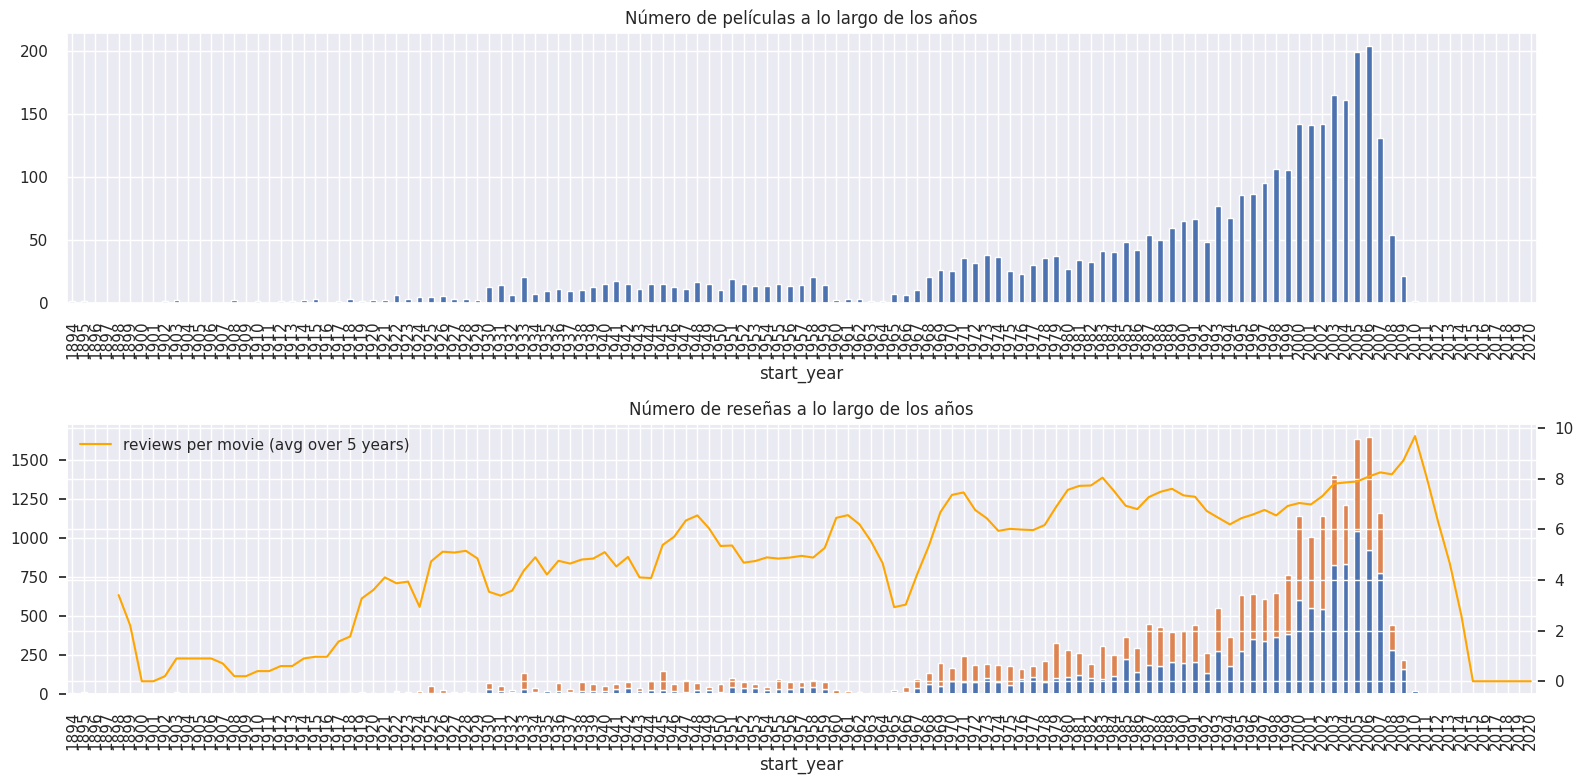

In [10]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de películas a lo largo de los años')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Número de reseñas a lo largo de los años')

fig.tight_layout()

Veamos la distribución del número de reseñas por película con el conteo exacto y KDE (solo para saber cómo puede diferir del conteo exacto)

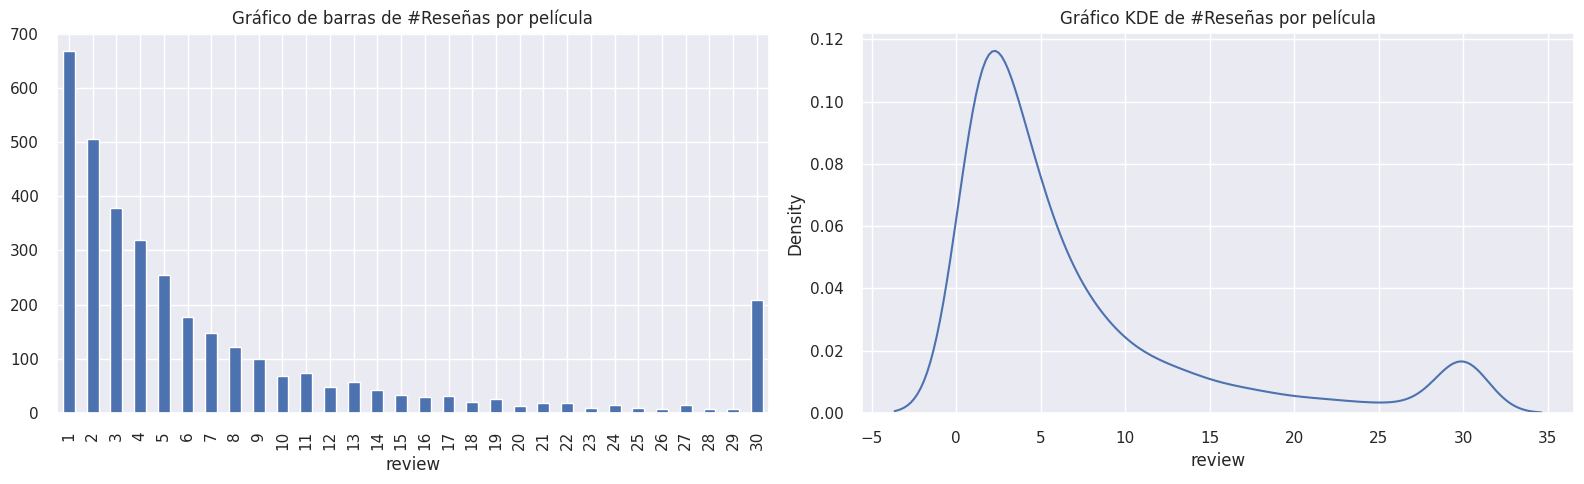

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de barras de #Reseñas por película')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico KDE de #Reseñas por película')

fig.tight_layout()

In [12]:
df_reviews['pos'].value_counts()

,count
pos,
0.0,12455
1.0,11820


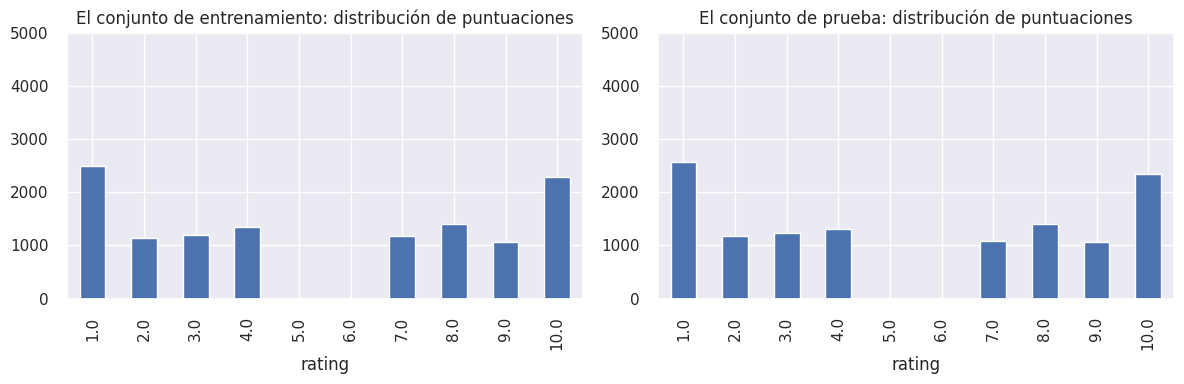

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de entrenamiento: distribución de puntuaciones')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de prueba: distribución de puntuaciones')

fig.tight_layout()

Distribución de reseñas negativas y positivas a lo largo de los años para dos partes del conjunto de datos

/tmp/ipython-input-1324160450.py:14: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
/tmp/ipython-input-1324160450.py:15: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
/tmp/ipython-input-1324160450.py:30: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
/tmp/ipython-input-1324160450.py:31: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your c

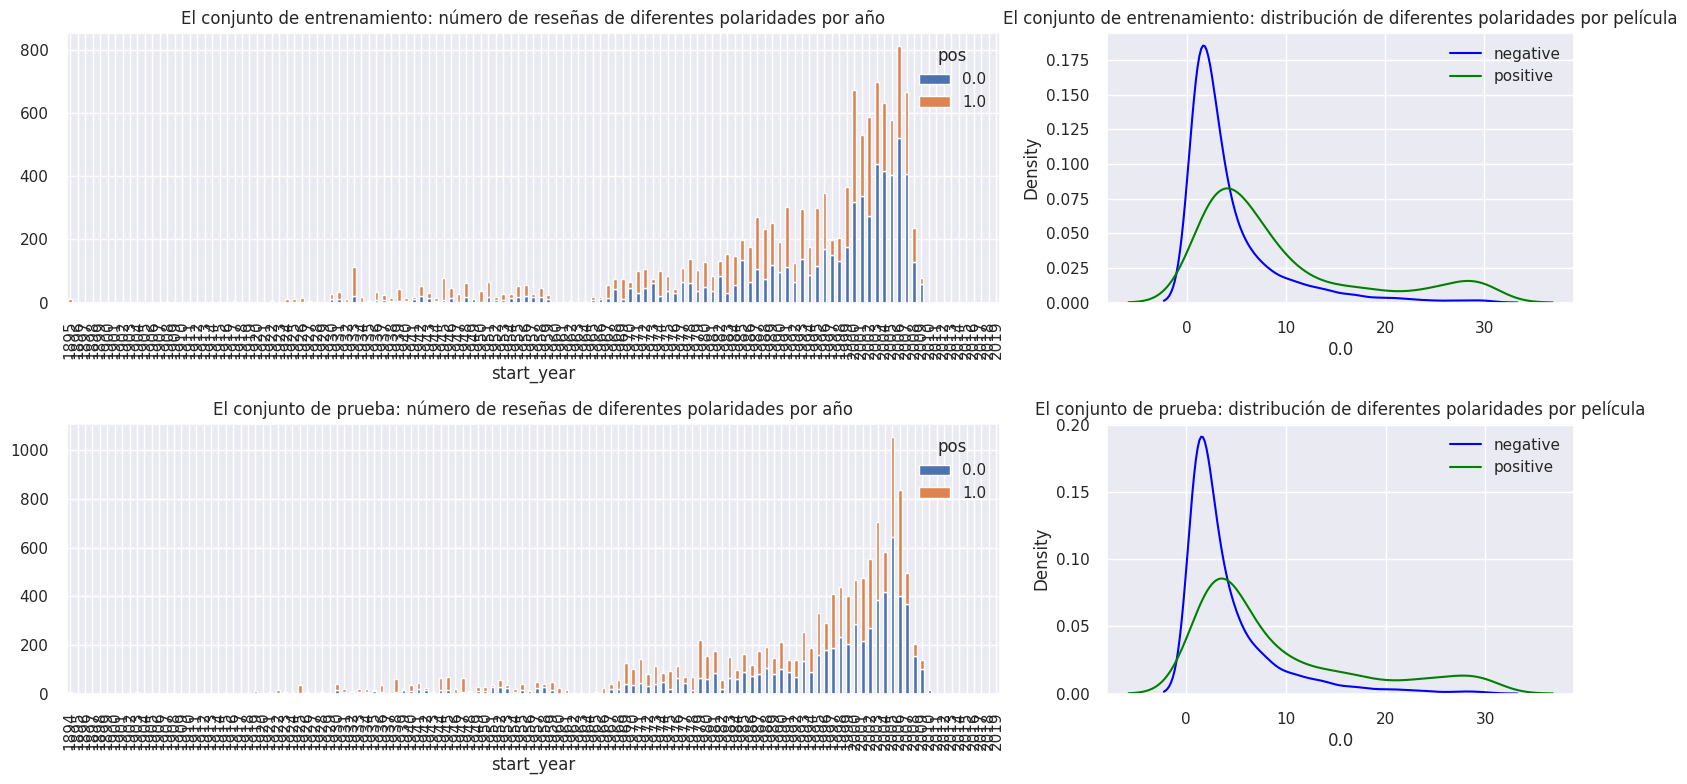

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de entrenamiento: número de reseñas de diferentes polaridades por año')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de entrenamiento: distribución de diferentes polaridades por película')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de prueba: número de reseñas de diferentes polaridades por año')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de prueba: distribución de diferentes polaridades por película')

fig.tight_layout()

## Procedimiento de evaluación

Composición de una rutina de evaluación que se pueda usar para todos los modelos en este proyecto

In [15]:
import sklearn.metrics as metrics
def evaluate_model(model, train_features, train_target, test_features, test_target):

    eval_stats = {}

    fig, axs = plt.subplots(1, 3, figsize=(20, 6))

    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):

        eval_stats[type] = {}

        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]

        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]

        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps

        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1')

        # ROC
        ax = axs[1]
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')
        ax.set_title(f'Curva ROC')

        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)

    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))

    print(df_eval_stats)

    return

## Normalización

Suponemos que todos los modelos a continuación aceptan textos en minúsculas y sin dígitos, signos de puntuación, etc.

In [16]:
df_reviews['review_norm'] = df_reviews['review'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x).lower())

## División entrenamiento / prueba

Por fortuna, todo el conjunto de datos ya está dividido en partes de entrenamiento/prueba; 'ds_part' es el indicador correspondiente.

In [17]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(12069, 18)
(12206, 18)


## Trabajar con modelos

### Modelo 0 - Constante

In [18]:
from sklearn.dummy import DummyClassifier

          train  test
Accuracy   0.51  0.52
F1         0.00  0.00
APS        0.49  0.48
ROC AUC    0.50  0.50


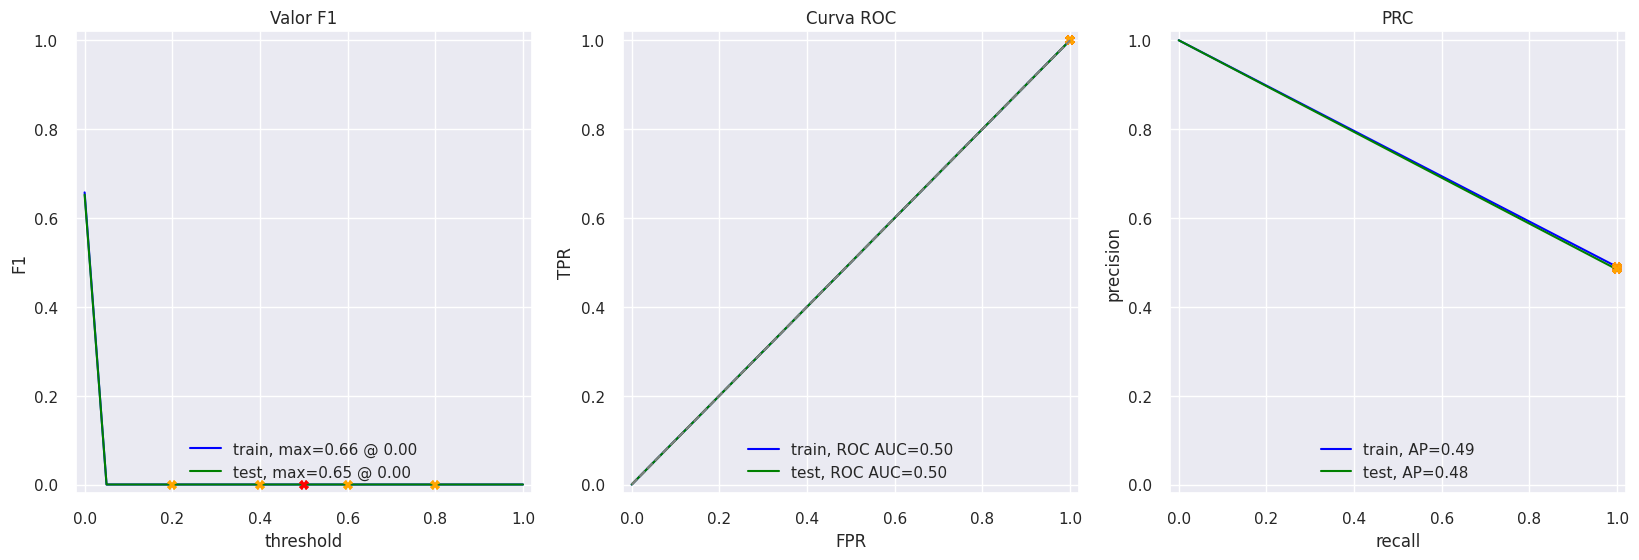

In [19]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(df_reviews_train['review_norm'], train_target)
evaluate_model(dummy_clf, df_reviews_train['review_norm'], train_target, df_reviews_test['review_norm'], test_target)

### Modelo 1 - NLTK, TF-IDF y LR

TF-IDF

In [20]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


          train  test
Accuracy   0.95  0.87
F1         0.95  0.87
APS        0.99  0.94
ROC AUC    0.99  0.94


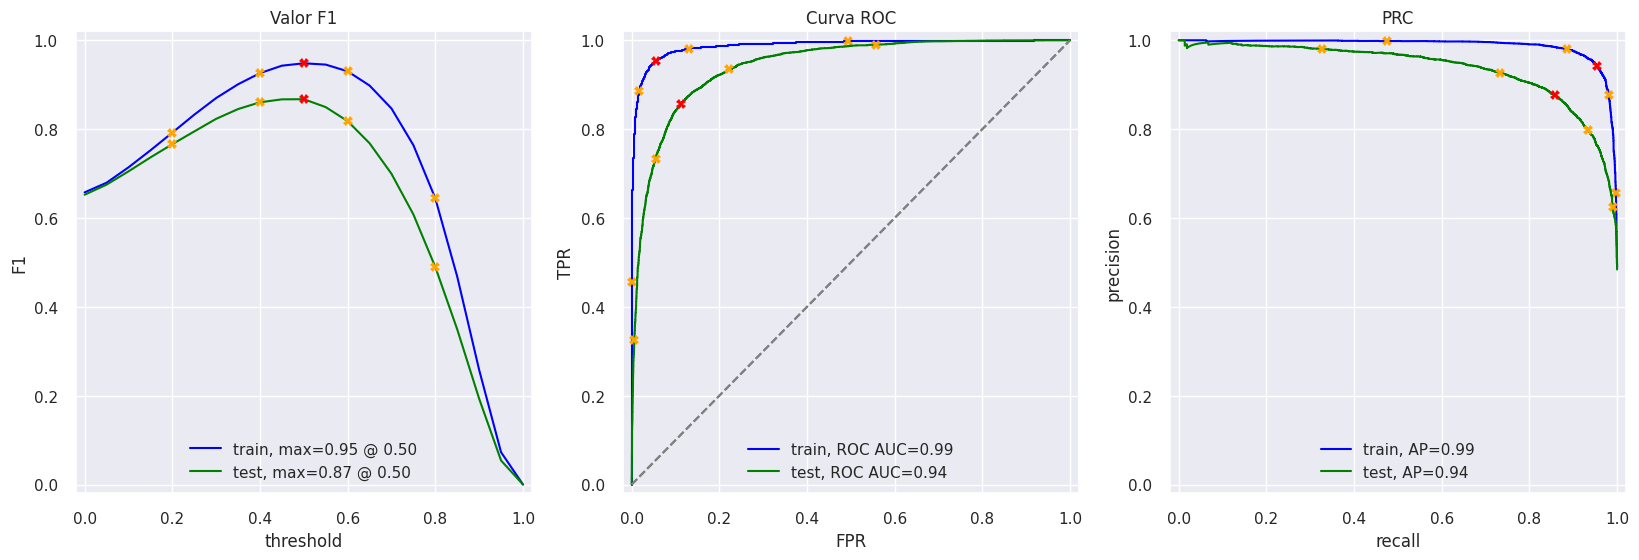

In [21]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

tfidf_vectorizer_1 = TfidfVectorizer(stop_words=list(stop_words))
train_features_1 = tfidf_vectorizer_1.fit_transform(df_reviews_train['review_norm'])
test_features_1 = tfidf_vectorizer_1.transform(df_reviews_test['review_norm'])

model_1 = LogisticRegression(random_state=12345)
model_1.fit(train_features_1, train_target)
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

### Modelo 3 - spaCy, TF-IDF y LR

In [22]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [23]:
def text_preprocessing_3(text):

    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]

    return ' '.join(tokens)

  0%|          | 0/12069 [00:00<?, ?it/s]

  0%|          | 0/12206 [00:00<?, ?it/s]

          train  test
Accuracy   0.93  0.87
F1         0.93  0.86
APS        0.98  0.94
ROC AUC    0.98  0.94


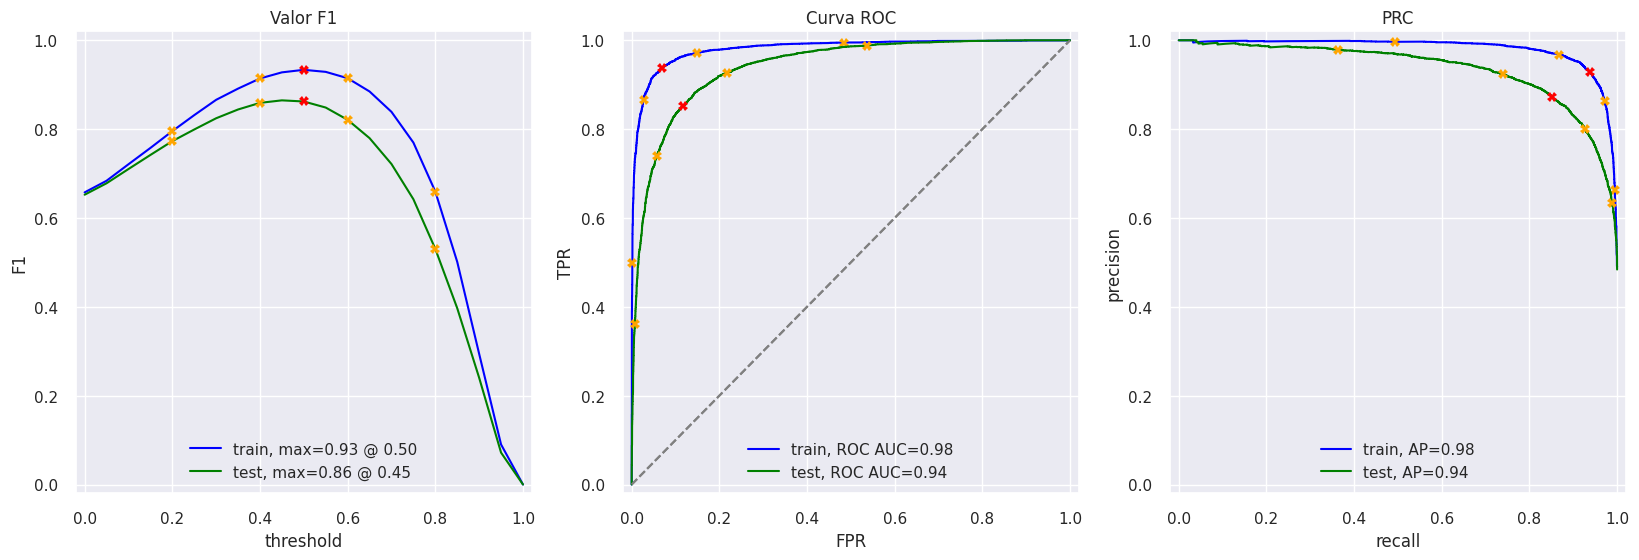

In [24]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def text_preprocessing_3(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc]
    return ' '.join(tokens)

tfidf_vectorizer_3 = TfidfVectorizer()
train_reviews_3 = df_reviews_train['review_norm'].progress_apply(text_preprocessing_3)
test_reviews_3 = df_reviews_test['review_norm'].progress_apply(text_preprocessing_3)

train_features_3 = tfidf_vectorizer_3.fit_transform(train_reviews_3)
test_features_3 = tfidf_vectorizer_3.transform(test_reviews_3)

model_3 = LogisticRegression(random_state=12345)
model_3.fit(train_features_3, train_target)
evaluate_model(model_3, train_features_3, train_target, test_features_3, test_target)

### Modelo 4 - spaCy, TF-IDF y LGBMClassifier

In [25]:
from lightgbm import LGBMClassifier

[LightGBM] [Info] Number of positive: 5912, number of negative: 6157
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.808026 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 276969
[LightGBM] [Info] Number of data points in the train set: 12069, number of used features: 5983
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.489850 -> initscore=-0.040605
[LightGBM] [Info] Start training from score -0.040605


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


          train  test
Accuracy   0.96  0.85
F1         0.96  0.85
APS        0.99  0.93
ROC AUC    0.99  0.93


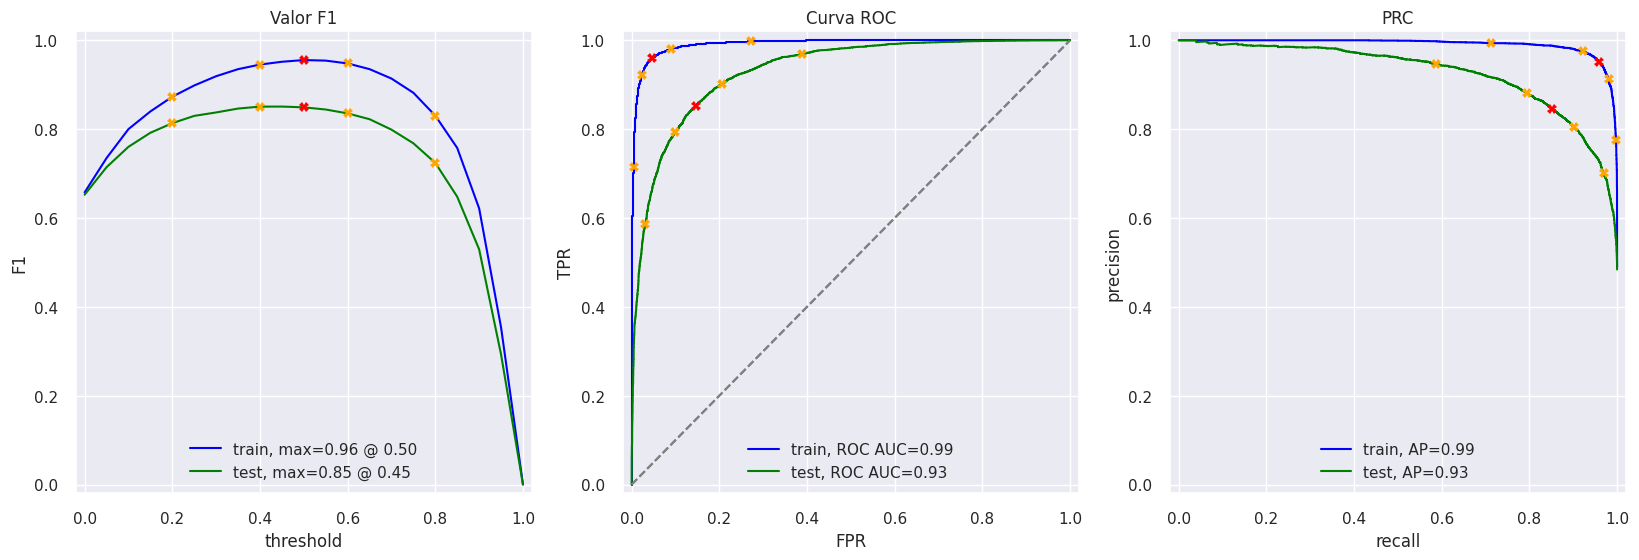

In [26]:
model_4 = LGBMClassifier(random_state=12345)
model_4.fit(train_features_3, train_target)
evaluate_model(model_4, train_features_3, train_target, test_features_3, test_target)

###  Modelo 9 - BERT

In [27]:
import torch
import transformers

In [28]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [29]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):

    ids_list = []
    attention_mask_list = []

    # 1. Tokenización: Convertir texto a IDs y crear máscaras de atención
    # Bucle a través de cada texto en la serie de pandas 'texts'
    for text in texts:
        # El tokenizador convierte el texto en un formato que BERT entiende.
        # 'encode_plus' hace varias cosas a la vez:
        # - add_special_tokens=True: Añade los tokens [CLS] al inicio y [SEP] al final.
        # - max_length: Trunca o rellena la oración a esta longitud.
        # - padding='max_length': Rellena las oraciones más cortas con ceros para que todas tengan el mismo tamaño.
        # - truncation=True: Corta las oraciones más largas.
        encoded_dict = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt' # Devuelve tensores de PyTorch, aunque aquí solo extraemos las listas.
        )

        # 'input_ids' es la lista de números que representa el texto.
        ids_list.append(encoded_dict['input_ids'].flatten().tolist())

        # La 'attention_mask' es una lista de 1s y 0s.
        # BERT presta atención a los tokens con '1' (palabras reales) e ignora los de '0' (relleno).
        attention_mask_list.append(encoded_dict['attention_mask'].flatten().tolist())


    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model.to(device)
    if not disable_progress_bar:
        print(f'Uso del dispositivo {device}.')

    embeddings = []

    # 2. Procesamiento en Lotes: Obtener los embeddings
    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):

        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)

        # Crear el lote para la máscara de atención, igual que para los IDs.
        attention_mask_batch = torch.FloatTensor(attention_mask_list[batch_size*i:batch_size*(i+1)]).to(device)

        with torch.no_grad():
            model.eval()
            # Pasar ambos lotes (IDs y máscara) al modelo
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)

        # 3. Extracción del Embedding [CLS]:
        # La salida de BERT contiene los embeddings de todos los tokens.
        # Para tareas de clasificación, se usa convencionalmente el embedding del primer token ([CLS]),
        # ya que representa el significado agregado de toda la secuencia.
        # batch_embeddings[0] -> Accede a los embeddings de la última capa.
        # [:, 0, :] -> Selecciona el embedding del token [CLS] para todas las oraciones del lote.
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())

    return np.concatenate(embeddings)


In [30]:
# ¡Atención! La ejecución de BERT para miles de textos puede llevar mucho tiempo en la CPU, al menos varias horas
train_features_9 = BERT_text_to_embeddings(df_reviews_train['review_norm'])

Uso del dispositivo cuda.


  0%|          | 0/121 [00:00<?, ?it/s]

In [31]:
print(df_reviews_train['review_norm'].shape)
print(train_features_9.shape)
print(train_target.shape)

(12069,)
(12069, 768)
(12069,)


In [36]:

test_features_9 = BERT_text_to_embeddings(df_reviews_test['review_norm'])
np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)


with np.load('features_9.npz') as data:
  train_features_9 = data['train_features_9']
  test_features_9 = data['test_features_9']



Uso del dispositivo cuda.


  0%|          | 0/123 [00:00<?, ?it/s]

## Mis reseñas

In [39]:

my_reviews['review_norm'] =  my_reviews['review'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x).lower())

my_reviews


,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didnt expect the reboot to be so good writer...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i reall...


### Modelo 2

In [44]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_1.predict_proba(tfidf_vectorizer_1.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.23:  i did not simply like it not my kind of movie
0.22:  well i was bored and felt asleep in the middle of the movie
0.50:  i was really fascinated with the movie
0.15:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.34:  i didnt expect the reboot to be so good writers really cared about the source material
0.32:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.11:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.85:  launching on netflix was a brave move  i really appreciate being able to binge on episode after epis


### Modelo 3

In [42]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.23:  i did not simply like it not my kind of movie
0.30:  well i was bored and felt asleep in the middle of the movie
0.54:  i was really fascinated with the movie
0.20:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.27:  i didnt expect the reboot to be so good writers really cared about the source material
0.58:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.08:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.85:  launching on netflix was a brave move  i really appreciate being able to binge on episode after epis


### Modelo 4

In [45]:
texts = my_reviews['review_norm']

tfidf_vectorizer_4 = tfidf_vectorizer_3
my_reviews_pred_prob = model_4.predict_proba(tfidf_vectorizer_4.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.59:  i did not simply like it not my kind of movie
0.72:  well i was bored and felt asleep in the middle of the movie
0.59:  i was really fascinated with the movie
0.55:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.59:  i didnt expect the reboot to be so good writers really cared about the source material
0.68:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.31:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.76:  launching on netflix was a brave move  i really appreciate being able to binge on episode after epis


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


### Modelo 9

In [48]:
from sklearn.linear_model import LogisticRegression

# Crear y entrenar el modelo de Regresión Logística con los embeddings de BERT
model_9 = LogisticRegression(random_state=12345, max_iter=1000)
model_9.fit(train_features_9, train_target)

print("Modelo 9 BERT entrenado con regresión logística")

texts = my_reviews['review_norm']

my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob = model_9.predict_proba(my_reviews_features_9)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

Modelo 9 BERT entrenado con regresión logística
0.12:  i did not simply like it not my kind of movie
0.00:  well i was bored and felt asleep in the middle of the movie
0.99:  i was really fascinated with the movie
0.00:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.13:  i didnt expect the reboot to be so good writers really cared about the source material
0.99:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.01:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.93:  launching on netflix was a brave move  i really appreciate being able to binge on episode after epis


## Conclusiones

Como conclusión puedo ofrecer que el aprendizaje automático aplicado a textos es muy útil en la industria. Ya que al usar estos modelos podemos ver el impacto que tiene la oferta en la demanda, o bien, estudiar con mejores técnicas las opiniones o sentimientos del consumidor en aras de mejorar la calidad de un producto.

También se puede hacer una clasificación de clientes en función a la propia respuesta al lanzamiento de un producto (que goza de ciertas características específicas).

Los modelos inscritos en este proyecto develan esa aplicación técnica, ya que el modleo 0 es la base del análisis en el sentido que de ahí parte el rendimiento mínimo que debe tener el trabajo de análisis de los datos. La métrica F1 nos indica que este modelo no es útil para identificar las opiniones positivas o negativas

En cuanto al desempeño del modelo 1, este clasifica correctamente el 87% de las reseñas en el conjunto de prueba, lo que es mucho mejor que en modelo 0, al tiempo que el valor de F1 es muy bueno, lo que nos dice que no es un modelo erroneo, al contrario, es un modelo robusto.

Refieriendome al modelo 3, este cumple también con un 86%, por lo que se puede categorizar como un modelo preciso. Además de que acierta en un 87% sus predicciones.

Ahora, en el modelo 4 igual se tienen unas muy buenas métricas. este modelo es robusto.

Estos modelos pueden ser usados para potenciar las decisiones productivas de las empresas, establecer buenas políticas públicas como en el sector salud.

# Lista de comprobación

- [x]  Abriste el notebook
- [ ]  Cargaste y preprocesaste los datos de texto para su vectorización
- [ ]  Transformaste los datos de texto en vectores
- [ ]  Entrenaste y probaste los modelos
- [ ]  Se alcanzó el umbral de la métrica
- [ ]  Colocaste todas las celdas de código en el orden de su ejecución
- [ ]  Puedes ejecutar sin errores todas las celdas de código
- [ ]  Hay conclusiones